# Copyright Netherlands eScience Center <br>
** Function     : Lead/Lag regression and energy budget - AMET (ERAI, MERRA2 and JRA55) & OMET (ORAS4) ** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.09.24 ** <br>
** Last Update  : 2019.10.14 ** <br>
Description  : This script serves to investigate the compensation between energy transport in the atmosphere and ocean. It works with AMET and OMET estimated from ERA-Interim and ORAS4. Lead/lag regressions are performed to check the compensation.<br>
Return Values : jpeg <br>
Caveat : The AMET is computed as the residual of net flux at TOA & surface. <br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer

Initialization - Start with location of input and extraction of variables
Time span of each product:
- **ERA-Interim** 1979 - 2016
- **MERRA2**      1980 - 2016
- **JRA55**       1979 - 2015
- **ORAS4**       1958 - 2017
- **GLORYS2V3**   1993 - 2014
- **SODA3**       1980 - 2015

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'HoF' : 334,        # heat of fusion of ice [KJ/Kg] 
            'rho_ice' : 0.91    # density of sea ice [g/cm3]
            }

In [3]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    datapath = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met'
    datapath_ERAI_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
    datapath_MERRA2_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/MERRA2/regression'
    datapath_JRA55_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/JRA55/regression'
    output_path = '/home/ESLT0068/NLeSC/PhD/Paperwork/Article/MET_Feedback/figures/revision/subFigures'
    #####################################################################################
    print ('*********************** extract variables *************************')
    dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
                                                    'surface_erai_monthly_regress_1979_2017_radiation.nc'))
    dataset_MERRA2_fields_flux = Dataset(os.path.join(datapath_MERRA2_fields,
                                                      'surface_merra_monthly_regress_1980_2017_SFlux_Rad.nc'))
    dataset_JRA55_fields_flux = Dataset(os.path.join(datapath_JRA55_fields,
                                                     'surface_JRA55_monthly_model_regress_SFlux_Rad_1979_2013.nc'))
    #dataset_ERAI_AMET = Dataset(os.path.join(datapath,
    #                            'era_model_subdaily_1979_2016_amet.nc'))
    dataset_ORAS4_OMET = Dataset(os.path.join(datapath,
                                 'oras_model_monthly_1958_2017_omet.nc'))
    # extract time series from 1979 to 2016
    # from 20N - 90N
    # 3D fields [year, month, lat]
    # since OMET is from 20N - 90N, AMET is from 90N to 20N, we have to reverse it
    # for interpolation, x should be monotonically increasing
    # 3D fields [year, month, lat]
    OMET_int_ORAS4 = dataset_ORAS4_OMET.variables['E_int'][21:-1,:,180:]/1000 # from Tera Watt to Peta Watt # start from 1979
    OMET_atl_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_int'][21:-1,:,180:]/1000
    #OMET_atl_100_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_100_int'][21:-1,:,180:]/1000
    #OMET_atl_300_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_300_int'][21:-1,:,180:]/1000
    #OMET_atl_700_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_700_int'][21:-1,:,180:]/1000
    #OMET_atl_2000_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_2000_int'][21:-1,:,180:]/1000
    # 3D fields [year, month, lat]
    # other dimensions
    year_ORAS4 = dataset_ORAS4_OMET.variables['year'][21:-1]    # from 1979 to 2016
    latitude_OMET_ORAS4 = dataset_ORAS4_OMET.variables['latitude_aux'][180:]
    
    latitude_fields_ERAI = dataset_ERAI_fields_flux.variables['latitude'][:]
    longitude_fields_ERAI = dataset_ERAI_fields_flux.variables['longitude'][:]
    # reverse the latitude of MERRA2 fields
    latitude_fields_MERRA2 = dataset_MERRA2_fields_flux.variables['latitude'][::-1]
    longitude_fields_MERRA2 = dataset_MERRA2_fields_flux.variables['longitude'][:]
    latitude_fields_JRA55 = dataset_JRA55_fields_flux.variables['latitude'][:]
    longitude_fields_JRA55 = dataset_JRA55_fields_flux.variables['longitude'][:]

*********************** extract variables *************************


In [30]:
    print(latitude_fields_ERAI[68])
    print(latitude_fields_MERRA2[102])
    print(latitude_fields_JRA55[89])

39.0
39.0
39.594326


In [4]:
    #####################################################################################
    print ('*********************** post-process 4D fields *************************')    
    # 4D fields [year, month, level, lat]
    # downward is positive for all the fluxes
    print ('*********************** post-process era fields *************************')
    rad_short_toa_ERAI = dataset_ERAI_fields_flux.variables['tsr'][:-1,:,:,:]
    rad_long_toa_ERAI = dataset_ERAI_fields_flux.variables['ttr'][:-1,:,:,:]
    rad_short_surf_ERAI = dataset_ERAI_fields_flux.variables['ssr'][:-1,:,:,:]
    rad_long_surf_ERAI = dataset_ERAI_fields_flux.variables['str'][:-1,:,:,:]
    SFlux_sensible_ERAI = dataset_ERAI_fields_flux.variables['sshf'][:-1,:,:,:]
    SFlux_latent_ERAI = dataset_ERAI_fields_flux.variables['slhf'][:-1,:,:,:]
    # calculate total net energy flux at TOA/surface
    net_flux_surf_ERAI = rad_short_surf_ERAI[:] + rad_long_surf_ERAI[:] +\
                         SFlux_sensible_ERAI[:] + SFlux_latent_ERAI[:]
    net_flux_toa_ERAI = rad_short_toa_ERAI[:] + rad_long_toa_ERAI[:]    
    # save memory
    del rad_short_toa_ERAI, rad_long_toa_ERAI, rad_short_surf_ERAI, rad_long_surf_ERAI
    del SFlux_sensible_ERAI, SFlux_latent_ERAI    
    print ('*********************** post-process merra fields *************************')
    rad_short_toa_MERRA2 = dataset_MERRA2_fields_flux.variables['SWTNT'][:-1,:,:,:]
    rad_long_toa_MERRA2 = dataset_MERRA2_fields_flux.variables['LWTUP'][:-1,:,:,:]
    rad_short_surf_MERRA2 = dataset_MERRA2_fields_flux.variables['SWGNT'][:-1,:,:,:]
    rad_long_surf_MERRA2 = dataset_MERRA2_fields_flux.variables['LWGNT'][:-1,:,:,:]
    SFlux_sensible_MERRA2 = dataset_MERRA2_fields_flux.variables['HFLUX'][:-1,:,:,:]
    SFlux_latent_MERRA2 = dataset_MERRA2_fields_flux.variables['EFLUX'][:-1,:,:,:]
    # calculate total net energy flux at TOA/surface
    # merra - watch out! the sign
    # reverse the meridional coordinate of MERRA2 for the sake of the calc. of residual
    net_flux_surf_MERRA2 = rad_short_surf_MERRA2[:,:,::-1,:] + rad_long_surf_MERRA2[:,:,::-1,:] -\
                           SFlux_sensible_MERRA2[:,:,::-1,:] - SFlux_latent_MERRA2[:,:,::-1,:]
    net_flux_toa_MERRA2 = rad_short_toa_MERRA2[:,:,::-1,:] - rad_long_toa_MERRA2[:,:,::-1,:]
    del rad_short_toa_MERRA2, rad_long_toa_MERRA2, rad_short_surf_MERRA2, rad_long_surf_MERRA2
    del SFlux_sensible_MERRA2, SFlux_latent_MERRA2
    print ('*********************** post-process jra fields *************************')
    rad_net_toa_JRA55 = dataset_JRA55_fields_flux.variables['nRadT'][:]
    rad_net_surf_JRA55 = dataset_JRA55_fields_flux.variables['nRadS'][:]
    SFlux_sensible_JRA55 = dataset_JRA55_fields_flux.variables['SFlux'][:]
    SFlux_latent_JRA55 = dataset_JRA55_fields_flux.variables['LFlux'][:]
    # calculate total net energy flux at TOA/surface
    net_flux_surf_JRA55 = rad_net_surf_JRA55[:] + SFlux_sensible_JRA55[:] +\
                          SFlux_latent_JRA55[:]
    net_flux_toa_JRA55 = rad_net_toa_JRA55[:]
    del rad_net_surf_JRA55, SFlux_sensible_JRA55, SFlux_latent_JRA55
    print ('*********************** convert W/m2 to  *************************')
    # area weighted surface flux
    # era
    net_flux_surf_ERAI_area = np.zeros(net_flux_surf_ERAI.shape, dtype=float)
    net_flux_toa_ERAI_area = np.zeros(net_flux_toa_ERAI.shape, dtype=float)
    # merra
    net_flux_surf_MERRA2_area = np.zeros(net_flux_surf_MERRA2.shape, dtype=float)
    net_flux_toa_MERRA2_area = np.zeros(net_flux_toa_MERRA2.shape, dtype=float)
    # jra
    net_flux_surf_JRA55_area = np.zeros(net_flux_surf_JRA55.shape, dtype=float)
    net_flux_toa_JRA55_area = np.zeros(net_flux_toa_JRA55.shape, dtype=float) 
    #size of the grid box
    # era
    dx_ERAI = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_ERAI /
                                            360) / len(longitude_fields_ERAI) 
    dy_ERAI = np.pi * constant['R'] / len(latitude_fields_ERAI)
    # merra
    dx_MERRA2 = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_MERRA2 /
                                            360) / len(longitude_fields_MERRA2) 
    dy_MERRA2 = np.pi * constant['R'] / len(latitude_fields_MERRA2)
    # jra
    dx_JRA55 = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_JRA55 /
                                            360) / len(longitude_fields_JRA55) 
    dy_JRA55 = np.pi * constant['R'] / len(latitude_fields_JRA55)   
    # era
    for i in np.arange(len(latitude_fields_ERAI)):
        # change the unit to terawatt
        net_flux_surf_ERAI_area[:,:,i,:] = net_flux_surf_ERAI[:,:,i,:] * dx_ERAI[i] *\
                                           dy_ERAI / 1E+12
        net_flux_toa_ERAI_area[:,:,i,:] = net_flux_toa_ERAI[:,:,i,:] * dx_ERAI[i] *\
                                          dy_ERAI / 1E+12
    # merra
    for i in np.arange(len(latitude_fields_MERRA2)):
        # change the unit to terawatt
        net_flux_surf_MERRA2_area[:,:,i,:] = net_flux_surf_MERRA2[:,:,i,:] * dx_MERRA2[i] *\
                                           dy_MERRA2 / 1E+12
        net_flux_toa_MERRA2_area[:,:,i,:] = net_flux_toa_MERRA2[:,:,i,:] * dx_MERRA2[i] *\
                                          dy_MERRA2 / 1E+12
    # jra
    for i in np.arange(len(latitude_fields_JRA55)):
        # change the unit to terawatt
        net_flux_surf_JRA55_area[:,:,i,:] = net_flux_surf_JRA55[:,:,i,:] * dx_JRA55[i] *\
                                           dy_JRA55 / 1E+12
        net_flux_toa_JRA55_area[:,:,i,:] = net_flux_toa_JRA55[:,:,i,:] * dx_JRA55[i] *\
                                          dy_JRA55 / 1E+12

*********************** post-process 4D fields *************************
*********************** post-process era fields *************************
*********************** post-process merra fields *************************
*********************** post-process jra fields *************************
*********************** convert W/m2 to  *************************


In [5]:
    print ('Compute AMET as the residuals of net flux at TOA & surface.')
    print ('*********************** AMET - era fields *************************')
    # take the zonal integral of flux
    net_flux_surf_ERAI_int = np.sum(net_flux_surf_ERAI_area,3) / 1000 # PW
    net_flux_toa_ERAI_int = np.sum(net_flux_toa_ERAI_area,3) / 1000
    # AMET as the residual of net flux at TOA & surface
    AMET_res_ERAI = np.zeros(net_flux_surf_ERAI_int.shape)
    for i in np.arange(len(latitude_fields_ERAI)-1):
        AMET_res_ERAI[:,:,i] = -(np.sum(net_flux_toa_ERAI_int[:,:,0:i+1],2) -
                                np.sum(net_flux_surf_ERAI_int[:,:,0:i+1],2))
    print (AMET_res_ERAI.shape)
    # invert the latitudinal coordinate
    AMET_res_ERAI = AMET_res_ERAI[:,:,:68]
    AMET_res_ERAI_inv = AMET_res_ERAI[:,:,::-1]
    latitude_fields_ERAI_part = latitude_fields_ERAI[:68]
    latitude_fields_ERAI_inv = latitude_fields_ERAI_part[::-1]
    print ('*********************** AMET - merra fields *************************')
    # take the zonal integral of flux
    net_flux_surf_MERRA2_int = np.sum(net_flux_surf_MERRA2_area,3) / 1000 # PW
    net_flux_toa_MERRA2_int = np.sum(net_flux_toa_MERRA2_area,3) / 1000
    # AMET as the residual of net flux at TOA & surface
    AMET_res_MERRA2 = np.zeros(net_flux_surf_MERRA2_int.shape)
    for i in np.arange(len(latitude_fields_MERRA2)-1):
        AMET_res_MERRA2[:,:,i] = -(np.sum(net_flux_toa_MERRA2_int[:,:,0:i+1],2) -
                                np.sum(net_flux_surf_MERRA2_int[:,:,0:i+1],2))
    print (AMET_res_MERRA2.shape)
    AMET_res_MERRA2 = AMET_res_MERRA2[:,:,:102]
    AMET_res_MERRA2_inv = AMET_res_MERRA2[:,:,::-1]
    latitude_fields_MERRA2_part = latitude_fields_MERRA2[:102]
    latitude_fields_MERRA2_inv = latitude_fields_MERRA2_part[::-1]
    print ('*********************** AMET - jra fields *************************')
    # take the zonal integral of flux
    net_flux_surf_JRA55_int = np.sum(net_flux_surf_JRA55_area,3) / 1000 # PW
    net_flux_toa_JRA55_int = np.sum(net_flux_toa_JRA55_area,3) / 1000
    # AMET as the residual of net flux at TOA & surface
    AMET_res_JRA55 = np.zeros(net_flux_surf_JRA55_int.shape)
    for i in np.arange(len(latitude_fields_JRA55)-1):
        AMET_res_JRA55[:,:,i] = -(np.sum(net_flux_toa_JRA55_int[:,:,0:i+1],2) -
                                np.sum(net_flux_surf_JRA55_int[:,:,0:i+1],2))
    print (AMET_res_JRA55.shape)
    AMET_res_JRA55 = AMET_res_JRA55[:,:,:89]
    AMET_res_JRA55_inv = AMET_res_JRA55[:,:,::-1]
    latitude_fields_JRA55_part = latitude_fields_JRA55[:89]
    latitude_fields_JRA55_inv = latitude_fields_JRA55_part[::-1]

Compute AMET as the residuals of net flux at TOA & surface.
*********************** AMET - era fields *************************
(38, 12, 241)
*********************** AMET - merra fields *************************
(37, 12, 361)
*********************** AMET - jra fields *************************
(35, 12, 320)


Perform interpolation as AMET and OMET has different resoltion in terms of the latitudes.

In [11]:
    print ('*******************  interpolation for regression   **********************')
    # interpolate OMET on the latitude of AMET
    # ORAS4 - ERAI
    # glole
    #OMET_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OMET_int_ORAS4, 
    #                             latitude_OMET_ORAS4, latitude_fields_ERAI_part[::-1])
    # atlantic
    OMET_atl_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OMET_atl_int_ORAS4, 
                                 latitude_OMET_ORAS4, latitude_fields_ERAI_inv)
    # an easy check for the interpolation
    #plt.plot(latitude_AMET_ERAI,OMET_atl_ORAS4_interp_ERAI[2,11,:],linewidth=6.0)
    #plt.plot(latitude_OMET_ORAS4,OMET_atl_int_ORAS4[2,11,:])
    
    # ORAS4 - MERRA2
    OMET_ORAS4_interp_MERRA2 = meta.statistics.operator.interpolation(OMET_int_ORAS4, 
                                 latitude_OMET_ORAS4, latitude_fields_MERRA2_inv)
    # atlantic
    OMET_atl_ORAS4_interp_MERRA2 = meta.statistics.operator.interpolation(OMET_atl_int_ORAS4, 
                                 latitude_OMET_ORAS4, latitude_fields_MERRA2_inv)
    # ORAS4 - JRA55
    OMET_ORAS4_interp_JRA55 = meta.statistics.operator.interpolation(OMET_int_ORAS4, 
                                 latitude_OMET_ORAS4, latitude_fields_JRA55_inv)
    # atlantic
    OMET_atl_ORAS4_interp_JRA55 = meta.statistics.operator.interpolation(OMET_atl_int_ORAS4, 
                                 latitude_OMET_ORAS4, latitude_fields_JRA55_inv)

*******************  interpolation for regression   **********************


In [25]:
print(latitude_fields_ERAI_inv[41])
print(latitude_fields_MERRA2_inv[61])
print(latitude_fields_JRA55_inv[54])

print(AMET_res_ERAI_inv.shape)
print(AMET_res_MERRA2_inv.shape)
print(AMET_res_JRA55_inv.shape)

print(OMET_atl_ORAS4_interp_JRA55.shape)
print(OMET_atl_ORAS4_interp_ERAI.shape)
print(OMET_atl_ORAS4_interp_MERRA2.shape)

70.5
70.0
70.48342
(38, 12, 68)
(37, 12, 102)
(35, 12, 89)
(38, 12, 89)
(38, 12, 68)
(38, 12, 102)


*******************  postprocess with statistical tool  *********************
***********!@#$%^&*  Lead/ Lag regression of ORAS4 - ERAI  !@#$%^&***********
======================   AMET + 0 & OMET + atl + 0   ========================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series with 2 dimensions is regressed on another.
This a regression with lead/lag analysis.
One time series with 2 dimensions is regressed on another.
This a regression with lead/lag analysis.
Create contour plot of correlation coefficient.


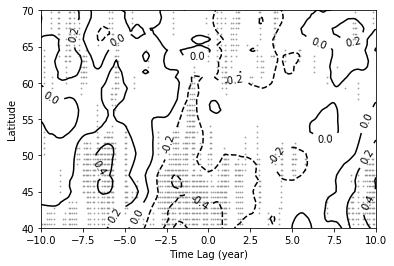

In [13]:
    print ('*******************  postprocess with statistical tool  *********************')
    print ('***********!@#$%^&*  Lead/ Lag regression of ORAS4 - ERAI  !@#$%^&***********')
    print ('======================   AMET + 0 & OMET + atl + 0   ========================')
    stat_AMET_ERAI = meta.statistics.operator(AMET_res_ERAI_inv)
    stat_AMET_ERAI.anomaly()
    stat_AMET_ERAI.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_AMET_ERAI.lowpass(window=12, obj='detrend')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_ORAS4_interp_ERAI)
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=12, obj='detrend')
    #k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
    #                                                 stat_OMET_ORAS4._lowpass)
    #meta.visualizer.plots.linearRegress(latitude_AMET_ERAI, r,
    #                                    os.path.join(output_path,'regress_ERAI_0_ORAS4_atl_0.png'))
    # set the lead lag
    lag = 120
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_OMET_ORAS4._lowpass, lag)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_AMET_ERAI._detrend,
                                                          stat_OMET_ORAS4._detrend, lag)
    # r[lag,lat]
    meta.visualizer.plots.leadlagRegress(latitude_fields_ERAI_inv[:42], r[:,:42], lag, p_real[:,:42],
                                         os.path.join(output_path,
                                         'leadlag_ERAI_ORAS4_atl_omet_annual.png'),
                                         ttest=True)

*******************  postprocess with statistical tool  *********************
***********!@#$%^&*  Lead/ Lag regression of ORAS4 - MERAA2  !@#$%^&***********
======================   AMET & OMET + atl   ========================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series with 2 dimensions is regressed on another.
This a regression with lead/lag analysis.
One time series with 2 dimensions is regressed on another.
This a regression with lead/lag analysis.
Create contour plot of correlation coefficient.


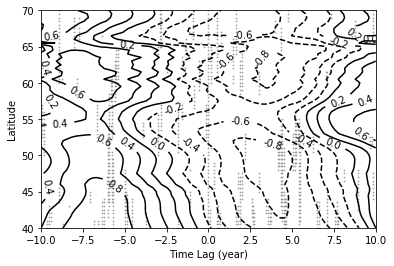

In [29]:
    print ('*******************  postprocess with statistical tool  *********************')
    print ('***********!@#$%^&*  Lead/ Lag regression of ORAS4 - MERAA2  !@#$%^&***********')
    print ('======================   AMET & OMET + atl   ========================')
    stat_AMET_MERRA2 = meta.statistics.operator(AMET_res_MERRA2_inv)
    stat_AMET_MERRA2.anomaly()
    stat_AMET_MERRA2.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_AMET_MERRA2.lowpass(window=120, obj='detrend')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_ORAS4_interp_MERRA2[1:,:,:])
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=120, obj='detrend')
    #k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
    #                                                 stat_OMET_ORAS4._lowpass)
    #meta.visualizer.plots.linearRegress(latitude_AMET_ERAI, r,
    #                                    os.path.join(output_path,'regress_ERAI_0_ORAS4_atl_0.png'))
    # set the lead lag
    lag = 120
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_MERRA2._lowpass,
                                                     stat_OMET_ORAS4._lowpass, lag)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_AMET_MERRA2._detrend,
                                                          stat_OMET_ORAS4._detrend, lag)
    # r[lag,lat]
    meta.visualizer.plots.leadlagRegress(latitude_fields_MERRA2_inv[:62], r[:,:62], lag, p_real[:,:62],
                                         os.path.join(output_path,
                                         'leadlag_MERRA2_ORAS4_atl_omet_decadal.png'),
                                         ttest=True)

*******************  postprocess with statistical tool  *********************
***********!@#$%^&*  Lead/ Lag regression of ORAS4 - JRA55  !@#$%^&***********
======================   AMET + 0 & OMET + atl + 0   ========================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series with 2 dimensions is regressed on another.
This a regression with lead/lag analysis.
One time series with 2 dimensions is regressed on another.
This a regression with lead/lag analysis.
Create contour plot of correlation coefficient.


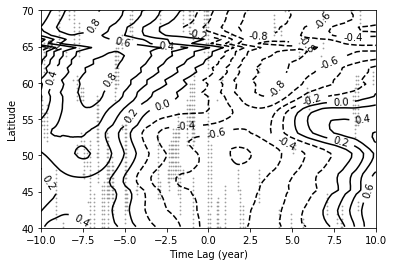

In [31]:
    print ('*******************  postprocess with statistical tool  *********************')
    print ('***********!@#$%^&*  Lead/ Lag regression of ORAS4 - JRA55  !@#$%^&***********')
    print ('======================   AMET + 0 & OMET + atl + 0   ========================')
    stat_AMET_JRA55 = meta.statistics.operator(AMET_res_JRA55_inv)
    stat_AMET_JRA55.anomaly()
    stat_AMET_JRA55.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_AMET_JRA55.lowpass(window=120, obj='detrend')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_ORAS4_interp_JRA55[:-3,:,:])
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=120, obj='detrend')
    #k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
    #                                                 stat_OMET_ORAS4._lowpass)
    #meta.visualizer.plots.linearRegress(latitude_AMET_ERAI, r,
    #                                    os.path.join(output_path,'regress_ERAI_0_ORAS4_atl_0.png'))
    # set the lead lag
    lag = 120
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_JRA55._lowpass,
                                                     stat_OMET_ORAS4._lowpass, lag)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_AMET_JRA55._detrend,
                                                          stat_OMET_ORAS4._detrend, lag)
    # r[lag,lat]
    meta.visualizer.plots.leadlagRegress(latitude_fields_JRA55_inv[:55], r[:,:55], lag, p_real[:,:55],
                                         os.path.join(output_path,
                                         'leadlag_JRA55_ORAS4_atl_omet_decadal.png'),
                                         ttest=True)